# ESDC Application

In [161]:
import sys

sys.path.insert(0, '/home/emmanuel/code/py_esdc')
sys.path.insert(0, '/home/emmanuel/projects/2019_sakame/')

# Standard libraries
import xarray as xr
import numpy as np
import pandas as pd
import h5py

# Data
from src.data.classification import load_esdc

# Feature Extraction/Transformations
from src.features.classification import add_drought_mask, extract_df, subset_time, extract_region
from src.features.stats import calculate_classification_stats
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from esdc.shape import rasterize
import geopandas as gpd

# SVM Model and Derivative functions
from src.models.classification import svm_naive, predict_batches
from src.models.derivatives import SVMDerivative

# Visualization
from src.visualization.utils import create_grid
from esdc.visualize import plot_xarray_on_map, plot_map
from src.visualization.classification import plot_toy_data, plot_predictions, plot_sensitivity
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
xr.set_options(display_style='html')
plt.style.use('ggplot')

# notebook extensions
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1.0 - Load Data

In [261]:
DATA_PROC_PATH = "/home/emmanuel/projects/2019_sakame/data/results/esdc/classification/"
FIG_PATH = "/home/emmanuel/projects/2019_sakame/reports/figures/esdc/classification/"

meta_vars = ['lat', 'lon', 'time']
input_vars = ['gross_primary_productivity', 'root_moisture']
output_vars = ['drought']

train = pd.read_csv(DATA_PROC_PATH + 'esdc_train.csv', index_col=[0,1,2])
test = pd.read_csv(DATA_PROC_PATH + 'esdc_test.csv', index_col=[0,1,2])

train.head()

,,,gross_primary_productivity,root_moisture,drought
lat,lon,time,,,
51.875,45.375,2010-07-24,0.215022,0.441141,1.0
52.125,36.625,2010-07-08,0.395502,0.561540,1.0
46.875,41.375,2010-07-24,0.203785,0.267833,1.0
56.375,54.125,2010-07-24,0.720203,0.280254,1.0
54.125,51.625,2010-07-08,0.362997,0.403068,1.0


In [173]:
train_norm = train.copy()
test_norm = test.copy()

scaler_clf = MinMaxScaler() #StandardScaler()

# fit standardize on training data
train_inputs_std = scaler_clf.fit_transform(train[input_vars])

train_norm[input_vars] = train_inputs_std

# # transform on test data
# test_inputs_std = scaler_clf.transform(test[input_vars])

# test_norm[input_vars] = test_inputs_std

## 2.0 - Load SVM Model

In [174]:
import joblib

EXP_NAME = "test"
MODEL_PATH = "/home/emmanuel/projects/2019_sakame/models/interim/"
model_name = "svm"

svm_model = joblib.load(f"{MODEL_PATH}{EXP_NAME}_{model_name}.jb")

## 3.0 - Predictions: Training Data

In [175]:
# initialize SVM Derivative Model
svm_der_model = SVMDerivative(svm_model)

(
    predictions, 
    derivatives, 
    decision_derivatives, 
    objective_derivatives, 
    mask_derivatives,
    kernel_derivatives
) = predict_batches(
    svm_model, 
    svm_der_model, 
    train[input_vars].values,
    train[output_vars].values,
    batch_size=1_000
)

### Calculate Statistics

Below is a helper function that takes in the labels, predictions and derivatives and returns an `xarray.Dataset` with the results that include the lat, lon and time components. This makes plotting a lot easier.

In [176]:
xr_results = calculate_classification_stats(
    ypred=predictions[:, None], 
    ytest=train[output_vars].values, 
    derivative=derivatives, 
    index=train[output_vars].index,
    obj_derivative=objective_derivatives,
    mask_derivative=mask_derivatives,
    kernel_derivative=kernel_derivatives,
    dec_derivative=decision_derivatives,
)
xr_results

<xarray.Dataset>
Dimensions:             (lat: 88, lon: 161, time: 3)
Coordinates:
  * lat                 (lat) float64 43.12 43.38 43.62 ... 64.38 64.62 64.88
  * lon                 (lon) float64 20.12 20.38 20.62 ... 59.62 59.88 60.12
  * time                (time) object '2010-07-08' '2010-07-16' '2010-07-24'
Data variables:
    Predictions         (lat, lon, time) float64 nan nan nan nan ... nan nan nan
    Labels              (lat, lon, time) float64 nan nan nan nan ... nan nan nan
    Sensitivity         (lat, lon, time) float64 nan nan nan nan ... nan nan nan
    Obj_Derivative      (lat, lon, time) float64 nan nan nan nan ... nan nan nan
    Dec_Derivative      (lat, lon, time) float64 nan nan nan nan ... nan nan nan
    Mask_Derivative     (lat, lon, time) float64 nan nan nan nan ... nan nan nan
    Kernel_Sensitivity  (lat, lon, time) float64 nan nan nan nan ... nan nan nan
Attributes:
    precision:  0.767379679144385
    f1:         0.6567505720823797
    accuracy:   0.85
    recall:     0.574

## 4.0 - Visualization

### 4.1 - Scatter Plots

In [177]:
import warnings
from typing import Tuple, Optional


def top_k_support_vectors(
    sv: np.ndarray, 
    weights: np.ndarray, 
    k: int=10
) -> Tuple[np.ndarray, np.ndarray]:
    """Takes a subset of the support vectors based on the top
    k highest weights. If k is equal to the number of support 
    vectors then we just return the sorted support vectors
    according to the weight.
    
    Parameters
    ----------
    sv : np.ndarray, (n_samples, n_features)
        the support vectors
    
    weights : np.ndarray, (n_samples, 1)
        the weight vector
    
    k : int, default=10
        the top k support vectors to take based on the 
        highest weights
    
    Returns
    -------
    idx : np.ndarray, (k)
        indices for the top k support vectors
    """
    if k >= sv.shape[0]:
        warnings.warn(f"k={k} > # of support vectors={sv.shape[0]}. Returning sorted support vectors.")
    
    # sort weights with index
    idx = np.argsort(weights[:, 0])[::-1]
    
    # subset k svs
    idx = idx[:k]
    
    return idx

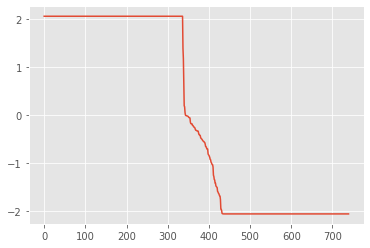

In [178]:
plt.plot(np.sort(svm_model.dual_coef_[0])[::-1])

In [217]:
k = 50
idx_k = top_k_support_vectors(
    sv=svm_model.support_vectors_,
    weights=svm_model.dual_coef_.T,
    k=k
)

In [340]:
# create grid
x_plot = create_grid(train_norm[input_vars].values, 100, (-0.1, -0.1))

# calculate the full derivative 
x_der = svm_der_model(x_plot)

#### 4.1.1 - Visualize the Predictions

In [341]:
def get_subset_idx(n_samples: int, subsamples: int=100, seed: int=123)-> np.ndarray:
    
    # create randomizer
    rng = check_random_state(123)
    
    return rng.permutation(n_samples)[:subsamples]

In [343]:
seed = 123
subsamples = 10_000
n_samples, n_features = train[input_vars].values.shape

idx_sub = get_subset_idx(n_samples, subsamples, seed)

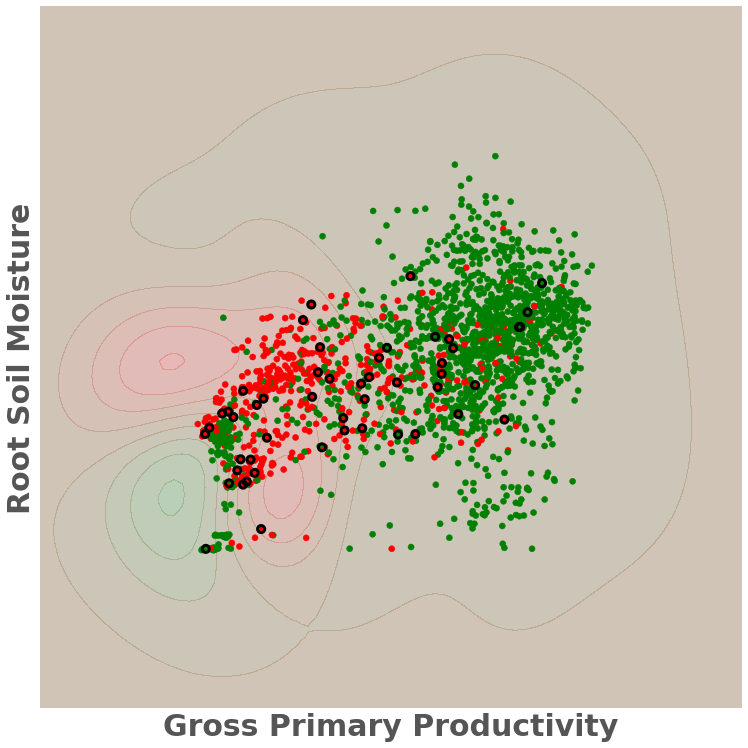

In [346]:
fig, ax = plot_predictions(
    xgrid=x_plot,
    decision_function=svm_model.decision_function,
    support_vectors=svm_model.support_vectors_[idx_k],
    xtest=train_norm[input_vars].values[idx_sub],
    ytest=train_norm[output_vars].values[idx_sub].squeeze(),
#     xtest=test[input_vars].values[idx_sub],
#     ytest=test[output_vars].values[idx_sub].squeeze(),
)
# ax.set_aspect(aspect='equal')
ax.set_xlabel('Gross Primary Productivity', fontsize=30, weight='bold')
ax.set_ylabel('Root Soil Moisture', fontsize=30, weight='bold')
fig.set_size_inches(10.5, 10.5)
plt.tight_layout()
save_name = "ee_svm_scatter_pred.png"
fig.savefig(FIG_PATH + save_name, transparent=True, dpi=100, bbox_inches = "tight")
plt.show()

#### 4.1.2 - Visualize the Sensitivity

In [365]:
sens_max = 0
sens_min = 0

seed = 123
subsamples = 10_000
n_samples, n_features = train[input_vars].values.shape

idx_sub = get_subset_idx(n_samples, subsamples, seed)

In [366]:
# create grid
x_plot = create_grid(test_norm[input_vars].values, 200, (0.05, 0.05))

# calculate the full derivative 
x_der = svm_der_model(x_plot)


# calculate the sensitivity
x_sens = np.abs(x_der).mean(axis=1)
sens_max = np.maximum(sens_max, x_sens.max())
sens_min = np.minimum(sens_min, x_sens.min())

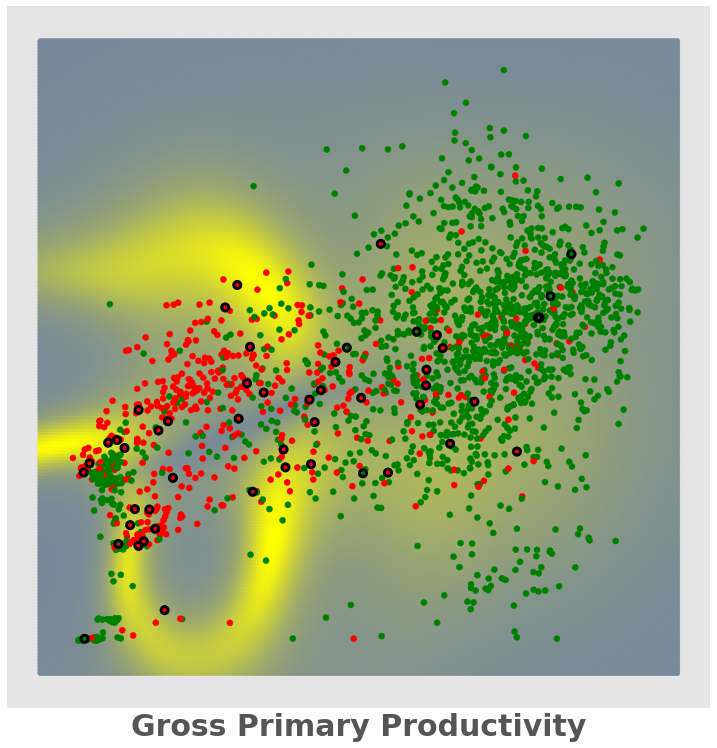

In [367]:
fig, ax = plot_sensitivity(
    xgrid=x_plot,
    sensitivity=x_sens,
    support_vectors=svm_model.support_vectors_[idx_k],
    xtest=train_norm[input_vars].values[idx_sub],
    ytest=train_norm[output_vars].values[idx_sub].squeeze(),
)
ax.set_xlabel('Gross Primary Productivity', fontsize=30, weight='bold')
# ax.set_ylabel('Root Soil Moisture', fontsize=30, weight='bold')
fig.set_size_inches(10.5, 10.5)
# ax.set_aspect(aspect='equal')
plt.tight_layout()
save_name = "ee_svm_scatter_sens.png"
fig.savefig(FIG_PATH + save_name, transparent=True, dpi=100, )
plt.show()

#### 4.1.3 - Mask Derivative

In [363]:
# create grid
x_plot = create_grid(test_norm[input_vars].values, 200, (0.05, 0.05))

# calculate the full derivative 
x_der = svm_der_model.mask_derivative(x_plot)


# calculate the sensitivity
x_sens = np.abs(x_der).mean(axis=1)

sens_max = np.maximum(sens_max, x_sens.max())
sens_min = np.minimum(sens_min, x_sens.min())

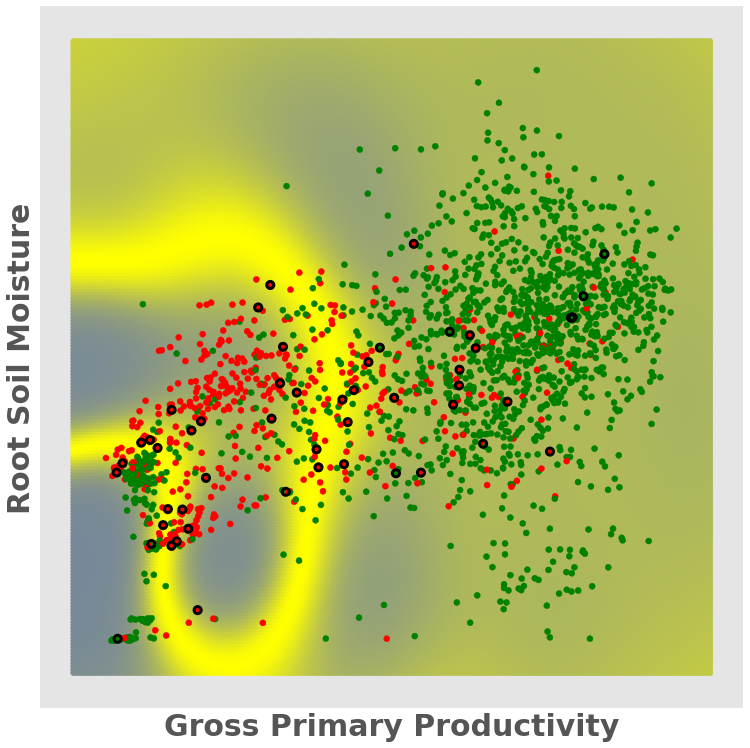

In [364]:
fig, ax = plot_sensitivity(
    xgrid=x_plot,
    sensitivity=x_sens,
    support_vectors=svm_model.support_vectors_[idx_k],
    xtest=train_norm[input_vars].values[idx_sub],
    ytest=train_norm[output_vars].values[idx_sub].squeeze(),
)

ax.set_xlabel('Gross Primary Productivity', fontsize=30, weight='bold')
ax.set_ylabel('Root Soil Moisture', fontsize=30, weight='bold')
fig.set_size_inches(10.5, 10.5)
plt.tight_layout()
save_name = "ee_svm_scatter_mask.png"
fig.savefig(FIG_PATH + save_name, transparent=True, dpi=100, )
plt.show()

#### 4.1.4 - Kernel Derivative

In [361]:
# create grid
x_plot = create_grid(test_norm[input_vars].values, 200, (0.05, 0.05))

# calculate the full derivative 
x_der = svm_der_model.kernel_derivative(x_plot)


# calculate the sensitivity
x_sens = np.abs(x_der).mean(axis=1)

sens_max = np.maximum(sens_max, x_sens.max())
sens_min = np.minimum(sens_min, x_sens.min())

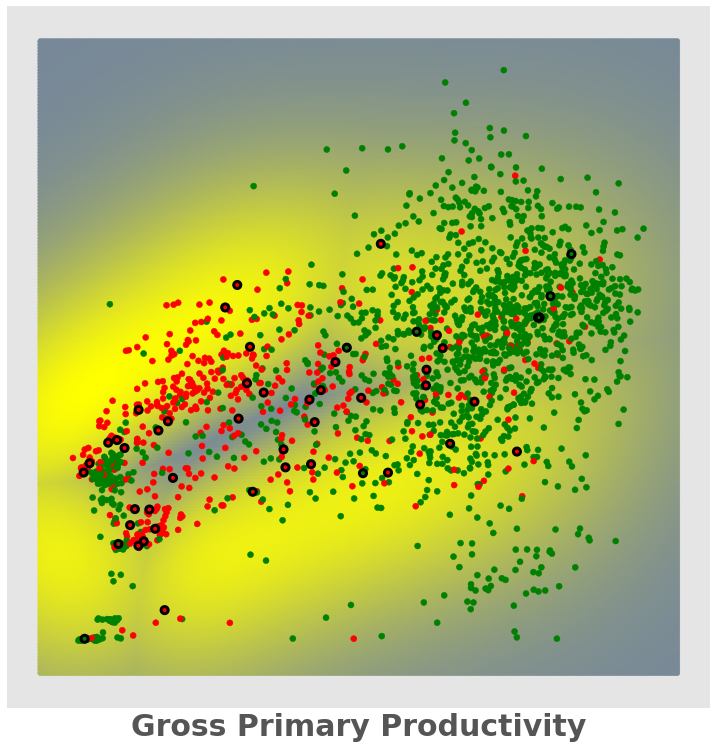

In [362]:
fig, ax = plot_sensitivity(
    xgrid=x_plot,
    sensitivity=x_sens,
    support_vectors=svm_model.support_vectors_[idx_k],
    xtest=train_norm[input_vars].values[idx_sub],
    ytest=train_norm[output_vars].values[idx_sub].squeeze(),
)

ax.set_xlabel('Gross Primary Productivity', fontsize=30, weight='bold')
# ax.set_ylabel('Root Soil Moisture', fontsize=30, weight='bold')
fig.set_size_inches(10.5, 10.5)
plt.tight_layout()
save_name = "ee_svm_scatter_kernel.png"
fig.savefig(FIG_PATH + save_name, transparent=True, dpi=100, )
plt.show()

In [354]:
sens_min, sens_max

(0.0, 609677.5792310416)

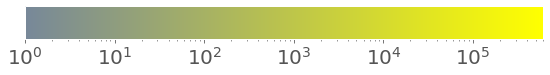

In [360]:
import matplotlib
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

fig = plt.figure(figsize=(8, 3))
ax = fig.add_axes([0.05, 0.80, 0.9, 0.15])
# cmap = matplotlib.cm.Reds
cmap = LinearSegmentedColormap.from_list("MyCmapName", ["#778899", "#FFFF00"])
norm = matplotlib.colors.LogNorm(vmin=1, vmax=sens_max)

cb = matplotlib.colorbar.ColorbarBase(
    ax, 
    cmap=cmap,   # Colormap
    norm=norm,
    orientation='horizontal',
)
# cb.ax.set_xticklabels(["Non-Drought", "Drought"], weight='bold', fontsize=20)
# cb.set_label('Sensitivity', fontsize=20, weight='bold')
cb.ax.tick_params(axis='both', which='major', labelsize=20)

save_name = "ee_svm_scatter_sens_cb.png"
fig.savefig(FIG_PATH + save_name, transparent=True, dpi=200, bbox_inches = "tight")

plt.show()

In [514]:
# initialize SVM Derivative Model
svm_der_model = SVMDerivative(svm_model)

(
    predictions, 
    derivatives, 
    decision_derivatives, 
    objective_derivatives, 
    mask_derivatives,
    kernel_derivatives
) = predict_batches(
    svm_model, 
    svm_der_model, 
    test[input_vars].values,
    test[output_vars].values,
    batch_size=10_000
)

In [515]:
xr_results = calculate_classification_stats(
    ypred=predictions[:, None], 
    ytest=test[output_vars].values, 
    derivative=derivatives, 
    index=test[output_vars].index,
    obj_derivative=objective_derivatives,
    mask_derivative=mask_derivatives,
    kernel_derivative=kernel_derivatives,
    dec_derivative=decision_derivatives,
)
xr_results

<xarray.Dataset>
Dimensions:             (lat: 88, lon: 161, time: 3)
Coordinates:
  * lat                 (lat) float64 43.12 43.38 43.62 ... 64.38 64.62 64.88
  * lon                 (lon) float64 20.12 20.38 20.62 ... 59.62 59.88 60.12
  * time                (time) datetime64[ns] 2010-07-08 2010-07-16 2010-07-24
Data variables:
    Predictions         (lat, lon, time) float64 1.0 0.0 1.0 0.0 ... 1.0 0.0 0.0
    Labels              (lat, lon, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Sensitivity         (lat, lon, time) float64 368.9 454.3 ... 563.3 510.7
    Obj_Derivative      (lat, lon, time) float64 0.01849 -0.1872 ... -0.1425
    Dec_Derivative      (lat, lon, time) float64 0.01849 -0.185 ... -0.1415
    Mask_Derivative     (lat, lon, time) float64 0.9997 0.9658 ... 0.9544 0.98
    Kernel_Sensitivity  (lat, lon, time) float64 369.0 470.4 ... 590.2 521.1
Attributes:
    precision:  0.6871329418045916
    f1:         0.6633593196314671
    accuracy:   0.8562902249848726
    recall:     0.6411757379499315

### Results - Classification Report

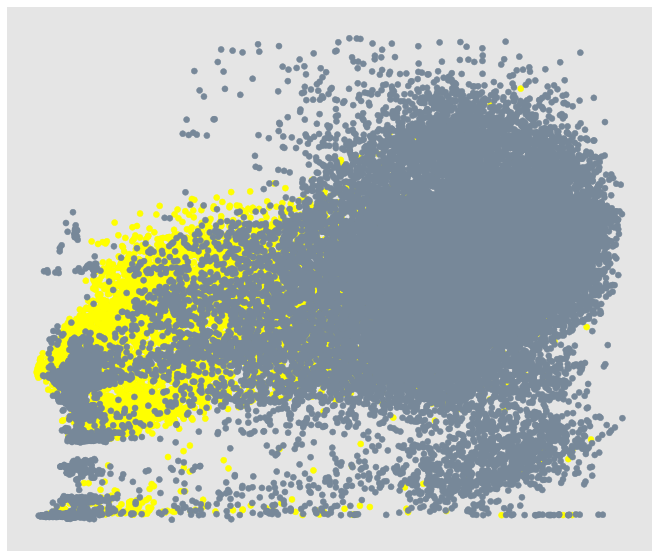

In [516]:
fig, ax = plot_sensitivity(
    xgrid=test[input_vars].values,
    sensitivity=test[output_vars].values.squeeze(),
#     support_vectors=svm_model.support_vectors_
)

# plt.tight_layout()
ax.set_aspect(aspect=20.)
# ax.legend([]'GPP', 'SM'])
plt.show()

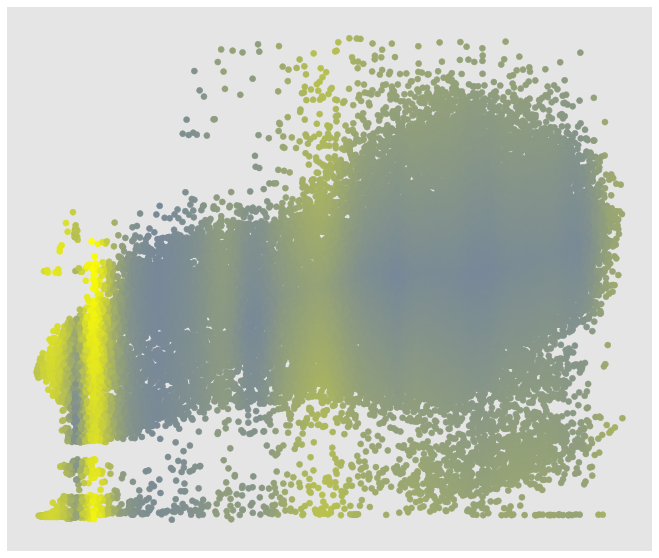

In [517]:
fig, ax = plot_sensitivity(
    xgrid=test[input_vars].values,
    sensitivity=np.abs(derivatives).mean(axis=1),
#     support_vectors=svm_model.support_vectors_[:10]
)

ax.set_aspect(aspect=20.)
plt.show()

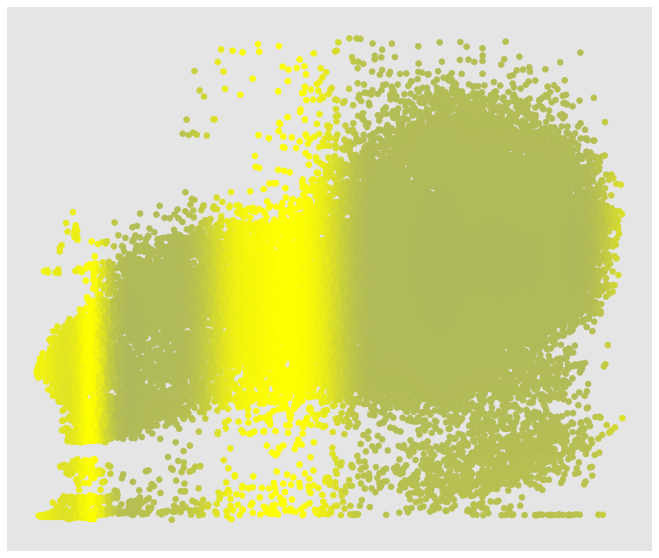

In [521]:
fig, ax = plot_sensitivity(
    xgrid=test[input_vars].values,
    sensitivity=np.abs(mask_derivatives).mean(axis=1),
#     support_vectors=svm_model.support_vectors_[:10]
)

ax.set_aspect(aspect=20.)
# plt.colorbar(ax)
plt.show()

In [522]:
from sklearn.metrics import classification_report


report = classification_report(
    predictions[:, None], 
    test[output_vars].values, 
    target_names=["Non-Drought", "Drought"]
)

print(report)

              precision    recall  f1-score   support

 Non-Drought       0.92      0.90      0.91     28866
     Drought       0.64      0.69      0.66      7492

    accuracy                           0.86     36358
   macro avg       0.78      0.79      0.79     36358
weighted avg       0.86      0.86      0.86     36358



### Visualization

### Viz - Classification Results

##### Classification Colorbar

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if __name__ == '__main__':


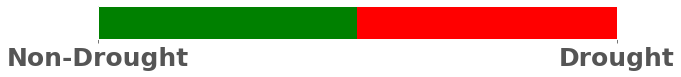

In [403]:
fig = plt.figure(figsize=(8, 3))
ax = fig.add_axes([0.05, 0.80, 0.9, 0.15])
cmap=ListedColormap(["g", "r"])
cb = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,
                                ticks=[0, 1],  # optional
                                spacing='proportional',
                                orientation='horizontal')
cb.ax.set_xticklabels(["Non-Drought", "Drought"], weight='bold', fontsize=25)
plt.tight_layout()
save_name = "ee_svm_pred_cb.png"
fig.savefig(SAVE_PATH + save_name, transparent=True, dpi=200, bbox_inches = "tight")
plt.show()

In [404]:
SAVE_PATH = "/home/emmanuel/projects/2019_sakame/reports/figures/esdc/classification/"

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


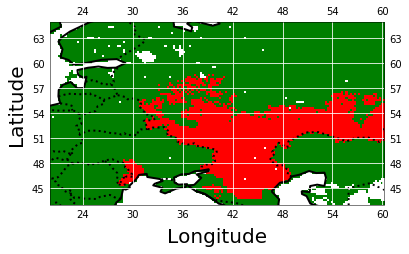

In [405]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib

cmap = ListedColormap(["g", "r"])
# cmap=plt.cm.get_cmap('RdBu_r', 2)
# cmap = matplotlib.colors.ListedColormap(["#778899", "#FFFF00"])
# cmap = plt.cm.get_cmap(cmap, 2)
cbar_kwargs = {
    'label':'Labels', 
    "fraction": 0.025, 
    "pad": 0.09, 
    "cmap": cmap,
    "ticks": [0, 1],
#     "xticklabels": ["Drought", "Not Drought"]
}

fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(), aspect='auto')
pts = xr_results.Labels.mean(dim='time').plot.imshow(
    ax=ax, 
    transform=cartopy.crs.PlateCarree(),
    add_colorbar=False,
    cmap=cmap
)
# cb = plt.colorbar(pts, orientation="horizontal", fraction=0.065, pad=0.25, ticks=[0, 1])
# cb.set_label(label='Labels', size='large', weight='bold', )
# cb.ax.tick_params(labelsize='large')
# cb.ax.set_yticks([0, 1])
# cb.ax.set_xticklabels(["Not-Drought", "Drought"])

ax.add_feature(cartopy.feature.BORDERS, linestyle=":", linewidth=2, )
ax.set_title('')

ax.coastlines(linewidth=2)
ax.gridlines(draw_labels=True)
ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
ax.text(0.5, -0.23, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
plt.tight_layout()

save_name = "ee_svm_labels.png"
fig.savefig(SAVE_PATH + save_name, transparent=True, dpi=100, bbox_inches = None)

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


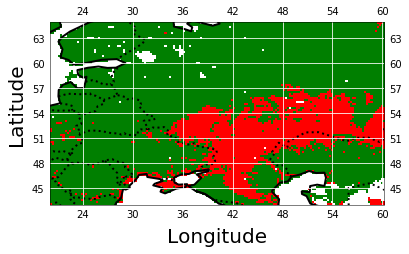

In [406]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib

# cmap=plt.cm.get_cmap('RdBu_r', 2)
cmap=ListedColormap(["g", "r"])
# cmap = LinearSegmentedColormap.from_list("MyCmapName", ["#778899", "#FFFF00"])
# cmap = plt.cm.get_cmap(cmap, 2)
cbar_kwargs = {
    'label':'Labels', 
    "fraction": 0.025, 
    "pad": 0.09, 
    "cmap": cmap,
    "ticks": [0, 1]
}

fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(), aspect='auto')
xr_results.Predictions.mean(dim='time').plot.imshow(
    ax=ax, 
    transform=cartopy.crs.PlateCarree(),
    add_colorbar=False,
    cmap=cmap
)
# cb = plt.colorbar(pts, orientation="horizontal", fraction=0.065, pad=0.25, ticks=[0, 1])
# cb.set_label(label='Labels', size='large', weight='bold', )
# cb.ax.tick_params(labelsize='large')
# cb.ax.set_yticks([0, 1])
# cb.ax.set_xticklabels(["Not-Drought", "Drought"])

ax.add_feature(cartopy.feature.BORDERS, linestyle=":", linewidth=2, )
ax.set_title('')

ax.coastlines(linewidth=2)
ax.gridlines(draw_labels=True)
ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
ax.text(0.5, -0.23, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
plt.tight_layout()

save_name = "ee_svm_predictions.png"
fig.savefig(SAVE_PATH + save_name, transparent=True, dpi=100, bbox_inches = None)

### Viz - Sensitivity

#### Colorbar

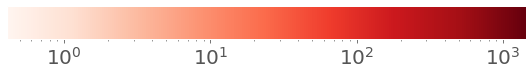

In [407]:
min_sens = np.minimum(
    xr_results.Sensitivity.mean(dim='time').min(),
    xr_results.Kernel_Sensitivity.mean(dim='time').min()
)
min_sens = np.minimum(
    min_sens,
    xr_results.Mask_Derivative.mean(dim='time').min()
)
max_sens = np.minimum(
    xr_results.Sensitivity.mean(dim='time').max(),
    xr_results.Kernel_Sensitivity.mean(dim='time').max()
)
max_sens = np.maximum(
    max_sens,
    xr_results.Mask_Derivative.mean(dim='time').max()
)

fig = plt.figure(figsize=(8, 3))
ax = fig.add_axes([0.05, 0.80, 0.9, 0.15])
cmap = matplotlib.cm.Reds
norm = matplotlib.colors.LogNorm(vmin=min_sens, vmax=max_sens)

cb = matplotlib.colorbar.ColorbarBase(
    ax, 
    cmap=cmap,   # Colormap
    norm=norm,
    orientation='horizontal'
)
# cb.ax.set_xticklabels(["Non-Drought", "Drought"], weight='bold', fontsize=20)
# cb.set_label('Sensitivity', fontsize=20, weight='bold')
cb.ax.tick_params(axis='both', which='major', labelsize=20)
plt.show()

save_name = "ee_svm_sens_cb.png"
fig.savefig(SAVE_PATH + save_name, transparent=True, dpi=200, bbox_inches = "tight")

#### Standard Predictions & Sensitivity

#### Viz - Mask Derivative

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


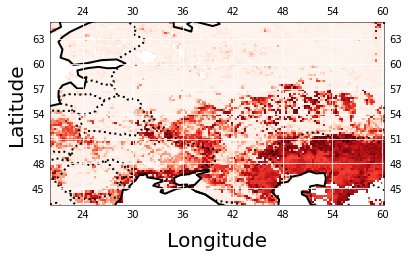

In [408]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib

cmap = "Reds"
# cmap=plt.cm.get_cmap('RdBu_r', 2)
# cmap = LinearSegmentedColormap.from_list("MyCmapName", ["#778899", "#FFFF00"])
# cmap = plt.cm.get_cmap("Reds", 2)
cbar_kwargs = {
    'label':'Sensitivity', 
    "fraction": 0.025, 
    "pad": 0.09, 
    "cmap": cmap,
    "ticks": [0, 1]
}


fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(), aspect='auto')
xr_results.Mask_Derivative.mean(dim='time').plot.imshow(
    ax=ax, 
    cmap=cmap,
#     norm=norm,
#     vmin=min_sens, vmax=max_sens,
    transform=cartopy.crs.PlateCarree(),
    add_colorbar=False,
#     norm = matplotlib.colors.LogNorm()
    
)
ax.add_feature(cartopy.feature.BORDERS, linestyle=":", linewidth=2, )
ax.set_title('')
ax.coastlines(linewidth=2)
ax.gridlines(draw_labels=True)
ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
ax.text(0.5, -0.25, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
plt.tight_layout()

save_name = "ee_svm_mask.png"
fig.savefig(SAVE_PATH + save_name, transparent=True, dpi=100, bbox_inches = None)

#### Kernel Derivative

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


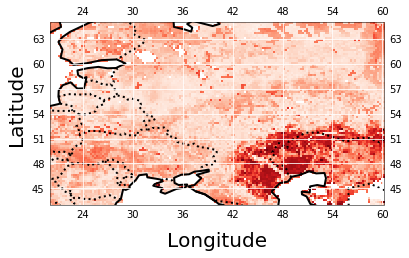

In [409]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib

cmap = "Reds"
# cmap=plt.cm.get_cmap('RdBu_r', 2)
# cmap = LinearSegmentedColormap.from_list("MyCmapName", ["#778899", "#FFFF00"])
# cmap = plt.cm.get_cmap("Reds", 2)
cbar_kwargs = {
    'label':'Sensitivity', 
    "fraction": 0.025, 
    "pad": 0.09, 
    "cmap": cmap,
    "ticks": [0, 1]
}


fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(), aspect='auto')
xr_results.Kernel_Sensitivity.mean(dim='time').plot.imshow(
    ax=ax, 
    cmap=cmap,
    vmin=min_sens, vmax=max_sens,
#     norm=norm,
    transform=cartopy.crs.PlateCarree(),
    add_colorbar=False,
#     norm = matplotlib.colors.LogNorm()
    
)
ax.add_feature(cartopy.feature.BORDERS, linestyle=":", linewidth=2, )
ax.set_title('')
ax.coastlines(linewidth=2)
ax.gridlines(draw_labels=True)
ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
ax.text(0.5, -0.25, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
plt.tight_layout()

save_name = "ee_svm_kernel.png"
fig.savefig(SAVE_PATH + save_name, transparent=True, dpi=100, bbox_inches = None)

#### Full Sensitivity

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


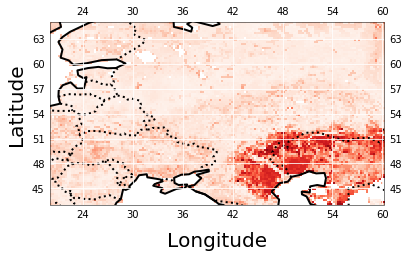

In [410]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib

cmap = "Reds"
# cmap=plt.cm.get_cmap('RdBu_r', 2)
# cmap = LinearSegmentedColormap.from_list("MyCmapName", ["#778899", "#FFFF00"])
# cmap = plt.cm.get_cmap("Reds", 2)
cbar_kwargs = {
    'label':'Sensitivity', 
    "fraction": 0.025, 
    "pad": 0.09, 
    "cmap": cmap,
    "ticks": [0, 1]
}



fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(), aspect='auto')
xr_results.Sensitivity.mean(dim='time').plot.imshow(
    ax=ax, 
    cmap=cmap,
#     norm=norm,
    transform=cartopy.crs.PlateCarree(),
    add_colorbar=False,
#     norm = matplotlib.colors.LogNorm()
    
)
ax.add_feature(cartopy.feature.BORDERS, linestyle=":", linewidth=2, )
ax.set_title('')
ax.coastlines(linewidth=2)
ax.gridlines(draw_labels=True)
ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
ax.text(0.5, -0.25, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor', fontsize=20,
        transform=ax.transAxes)
plt.tight_layout()

save_name = "ee_svm_sens.png"
fig.savefig(SAVE_PATH + save_name, transparent=True, dpi=100, bbox_inches = None)